In [1]:
import scanpy.api as sc
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, to_hex, Normalize
import seaborn as sns
from copy import deepcopy
from matplotlib import cm
%matplotlib inline

# Load in counts and pre-existing annotations from csv

In [2]:
## Init the full dataset
rawdata = sc.read('../data/Marrow-counts.csv').transpose() 
cell_annotation = pd.read_csv('../data/annotations_FACS.csv', index_col='cell') 
rawdata.obs['cell_type'] = cell_annotation.cell_ontology_class
rawdata.obs['mouse_id'] = cell_annotation['mouse.id']
rawdata.obs['mouse.sex'] = cell_annotation['mouse.sex']

## Normalize w/ seurat defaults
normed = sc.pp.recipe_seurat(rawdata, log=False, plot=False, copy=True)
immutable_annotations = rawdata.obs_keys() ## log which keys were present on load (note some are added during preprocessing)

/Users/sidneybell/Library/Python/3.7/lib/python/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Preprocess, compute embedding for 'universe'

In [3]:
## Preprocess, compute embedding for 'universe'
sc.pp.pca(normed)
sc.pp.neighbors(normed)
sc.tl.umap(normed)
sc.tl.louvain(normed)

In [9]:
normed.write('../../cellxgene/example-dataset/marrow.h5ad')

... storing 'cell_type' as categorical
... storing 'mouse_id' as categorical
... storing 'mouse.sex' as categorical


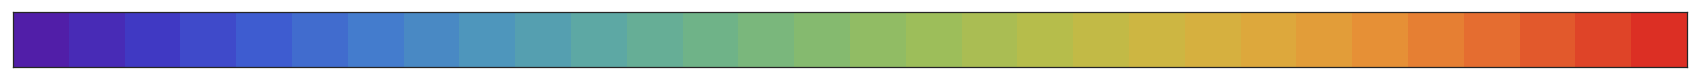

In [4]:
colors = ["#511EA8", "#482BB6", "#4039C3", "#3F4ACA", "#3E5CD0", "#416CCE", "#447CCD", "#4989C4", "#4E96BC", "#559FB0", "#5DA8A4", "#66AE96", "#6FB388", "#7AB77C", "#85BA6F", "#91BC64", "#9DBE5A", "#AABD53", "#B6BD4B", "#C2BA46", "#CDB642", "#D6B03F", "#DDA83C", "#E29D39", "#E69036", "#E67F33", "#E56D30", "#E2592C", "#DF4428", "#DC2F24"]
cmap = LinearSegmentedColormap.from_list('cmap', colors, N=len(colors))
palette = sns.color_palette(colors)
sns.set(style='white', font_scale=1.5)

sns.palplot(palette)

def assign_colors(vals, cmap=cmap):
    ''' return a dictionary of { value: (R,G,B,a) } '''
    if type(cmap) == str:
        cmap = cm.get_cmap(cmap)
    vals = set(vals)
    nvals = len(vals)
    
    colors = [cmap(i/nvals) for i in range(nvals)]
    
    return { val: colors[i] for i,val in enumerate(vals) }

In [5]:
def plot_umap(adata, colorby = 'cell_type', title=None, show=True):
    
    if colorby in adata.obs:        
        fig, ax = plt.subplots()
        color_dict = assign_colors(pd.unique(adata.obs[colorby]))
        colors = [ color_dict[k] for k in adata.obs[colorby] ]
        legend_handles = []
        for val, color in color_dict.items():
            patch = patches.Patch(color=color, label=val)
            legend_handles.append(patch)

        plt.legend(loc=(1,0),handles=legend_handles, ncol=2)

    elif colorby in adata.var_names:
        fig, (ax, cax) = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [1, 0.1]})
        plt.sca(ax)

        vals = adata[:, adata.var_names.isin([colorby])].X
        cmap = plt.cm.viridis
        norm = Normalize(np.percentile(vals, 2), np.percentile(vals, 98))
        colors = [plt.cm.viridis(norm(v)) for v in vals]
        
        colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical', 
                                alpha=0.5, label=colorby)   
        
    plt.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], c=colors, alpha=0.2)
    

    if title:
        ax.set_title(title)
        
    if show:
        plt.show()
    return fig, ax

# This brings us to where cellxgene intersects the user. 
# Plot universe, colored by pre-existing celltype annotation.

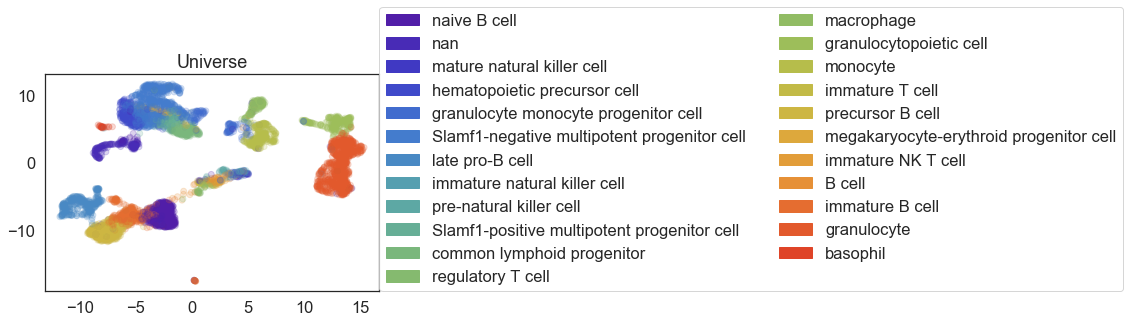

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x15189d160>)

In [7]:
plot_umap(normed, title='Universe')

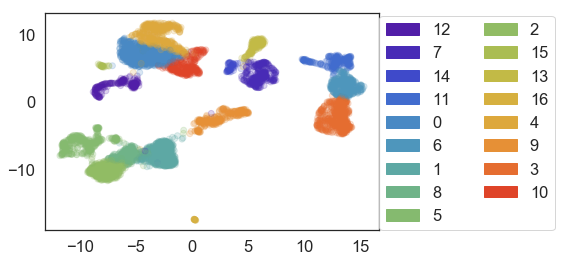

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1518dad30>)

In [8]:
plot_umap(normed, colorby='louvain')

# Let's try to find and annotate some proliferating B cells

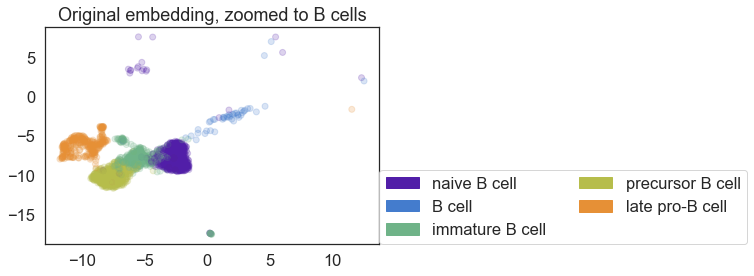

In [21]:
## Categorical selection based on cell type

cell_types = pd.unique(normed.obs['cell_type'].values)
B_cell_values = [c for c in cell_types if 'B cell' in str(c)]
B_cells = normed[normed.obs['cell_type'].isin(B_cell_values)]

fig, ax = plot_umap(B_cells, title='Original embedding, zoomed to B cells')


# First, find the B cells and look at structure

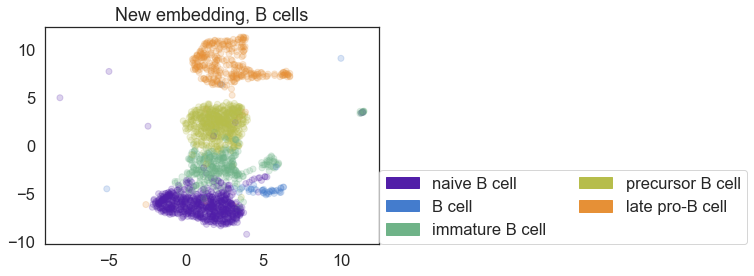

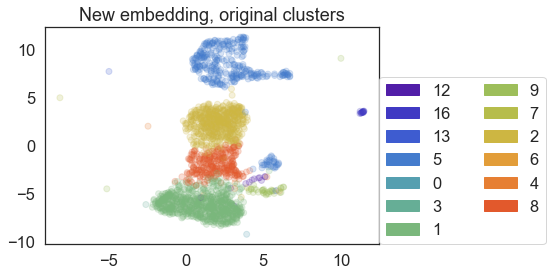

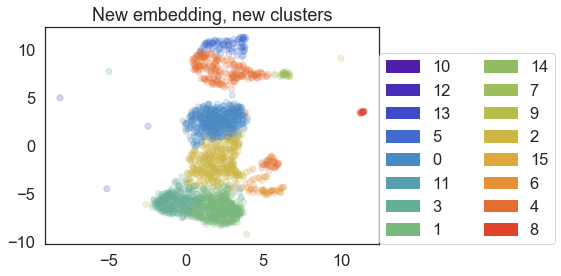

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x151bd7eb8>)

In [22]:
## Rerun umap & cluster just the B cells to look at local structure and increase resolution

sc.tl.umap(B_cells)
plot_umap(B_cells, colorby='cell_type', title="New embedding, B cells")
plot_umap(B_cells, colorby='louvain', title="New embedding, original clusters")
sc.tl.louvain(B_cells)
plot_umap(B_cells, colorby='louvain', title="New embedding, new clusters")



# Now look for which cells are expressing proliferation markers

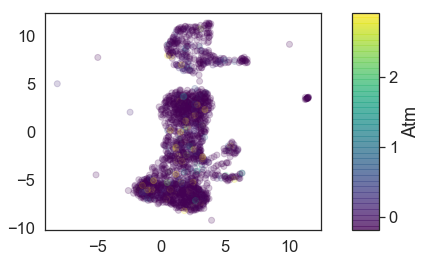

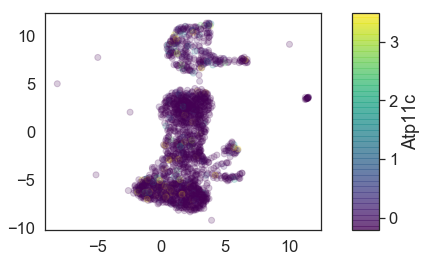

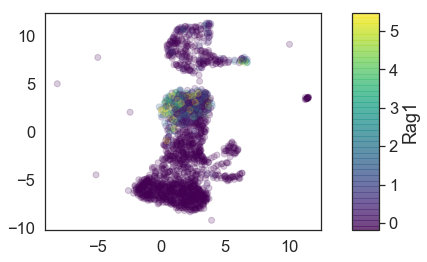

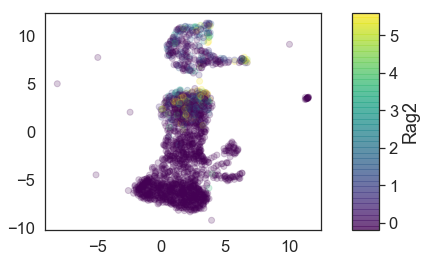

In [23]:
## Look for proliferation marker genes (via http://www.informatics.jax.org/go/term/GO:0002322 )
markers = ['Abl1', 'Atm', 'Atp11c', 'Cd24a', 'Fnip1', 'Foxp1', 'Irf2bp2', 'Kit', 'Mir17', 'Mir18', 'Mir19a', 'Mir20a', 'Rag1', 'Rag2']

for marker in markers:
    if marker in B_cells.var_names:    
        plot_umap(B_cells, marker)
    

# Isolate the relevant cell population
## Cross referencing clusters and marker gene expression, it looks like the cells in clusters 0 and 5 are expressing proliferation markers.

## Note that we could probably select this same population in the original embedding/clustering via the gene expression histogram + cell type annotations, but it wouldn't have been as clean and easy.


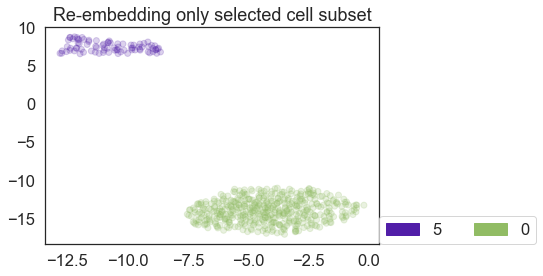

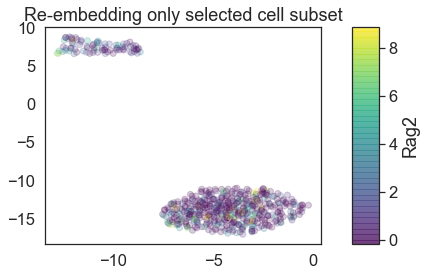

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1496150f0>)

In [24]:
prolif = B_cells[B_cells.obs['louvain'].isin(['0', '5',])]

sc.tl.umap(prolif)
plot_umap(prolif, 'louvain', title='Re-embedding only selected cell subset')
plot_umap(prolif, 'Rag2', title='Re-embedding only selected cell subset')

# Store the annotation
## Make a new column to store this annotation
## Alternatively, this could be implemented as a separate dataframe, but adding it directly to the anndata object in memory lets the rest of the plotting machinery access it easily


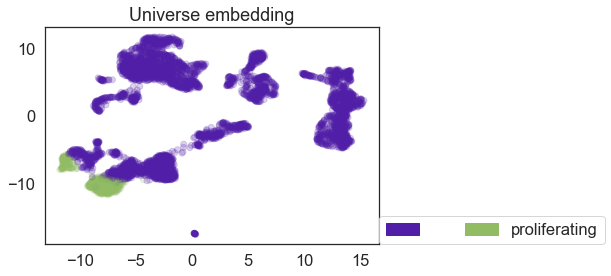

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x14967f0b8>)

In [25]:
prolif_index = prolif.obs_names # indices of proliferating cells
activation_state = []
for k in normed.obs_names: # label ALL cells in universe as in the subset or not
    if k in prolif_index: 
        activation_state.append('proliferating')
    else:
        activation_state.append(None)
    
normed.obs['activation'] = activation_state # add as a new obs column

plot_umap(normed, 'activation', title='Universe embedding')

In [27]:
print(normed.obs['activation'].head())

A22.D042044.3_9_M.1.1             None
C5.D042044.3_9_M.1.1     proliferating
D10.D042044.3_9_M.1.1    proliferating
E13.D042044.3_9_M.1.1             None
F19.D042044.3_9_M.1.1    proliferating
Name: activation, dtype: object


# Export to CSV. This allows later import as in the first cell.

In [28]:
normed.obs['activation'].to_csv('./demo_annotation.csv')